In [1]:
import tensorflow as tf
import os
import numpy as np
import time
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [43]:
!pip install kaggle

In [49]:
import os
import zipfile

# Set up Kaggle API key (make sure kaggle.json is in the same dir or ~/.kaggle)
os.environ['KAGGLE_CONFIG_DIR'] = "Kaggle Settings.json"

# Download dataset (use your real dataset slug here)
!kaggle datasets download -d bharatdeleepnair/brain-ct-sinograms-64-10000


Traceback (most recent call last):
  File "/Users/bharatdeleepnair/miniconda3/bin/kaggle", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/Users/bharatdeleepnair/miniconda3/lib/python3.12/site-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/bharatdeleepnair/miniconda3/lib/python3.12/site-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/bharatdeleepnair/miniconda3/lib/python3.12/site-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [63]:
# Paths
output_dir = 'Datasets/brain_CT_64_augmented'
input_dir = 'Datasets/brain_CT_sinograms_64_augmented'

# Get sorted file names (to ensure matching)
input_files = sorted(os.listdir(input_dir))
output_files = sorted(os.listdir(output_dir))


In [64]:
# Initialize lists
x_data = []
y_data = []

# Load images
for in_file, out_file in zip(input_files, output_files):
    # Load grayscale image and resize to (256, 256)
    input_img = load_img(os.path.join(input_dir, in_file), color_mode='grayscale', target_size=(91,64))
    output_img = load_img(os.path.join(output_dir, out_file), color_mode='grayscale', target_size=(64, 64))
    
    # Convert to array and normalize to [0, 1]
    x = img_to_array(input_img) / 255.0
    y = img_to_array(output_img) / 255.0

    x_data.append(x)
    y_data.append(y)

# Convert to NumPy arrays
x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)

print("Input shape:", x_data.shape)   # (125, 256, 256, 1)
print("Output shape:", y_data.shape)  # (125, 256, 256, 1)

Input shape: (10000, 91, 64, 1)
Output shape: (10000, 64, 64, 1)


In [65]:
x_train = x_data[:9500]
x_test = x_data[9500:]
y_train = y_data[:9500]
y_test = y_data[9500:]

In [66]:
print(x_train.shape)
print(y_train.shape)

(9500, 91, 64, 1)
(9500, 64, 64, 1)


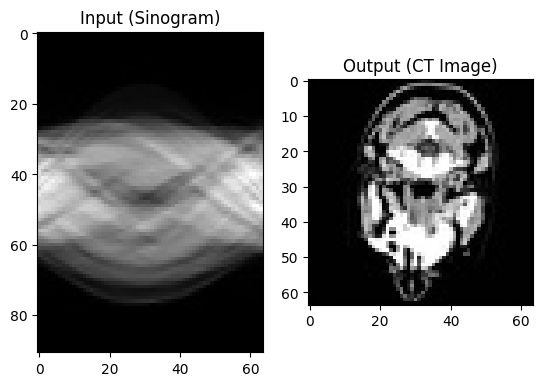

In [67]:
index = 4

import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(x_data[index].squeeze(), cmap='gray')
plt.title('Input (Sinogram)')

plt.subplot(1, 2, 2)
plt.imshow(y_data[index].squeeze(), cmap='gray')
plt.title('Output (CT Image)')
plt.show()

# Model

In [68]:
import tensorflow as tf

def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)
psnr_metric.__name__ = 'psnr_metric'

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)
ssim_metric.__name__ = 'ssim_metric'


In [69]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Sinusoidal Back-projection Layer
class SinusoidalBackProjection(layers.Layer):
    def __init__(self, out_height, out_width, **kwargs):
        super().__init__(**kwargs)
        self.out_height = out_height
        self.out_width = out_width

    def build(self, input_shape):
        input_dim = input_shape[-1]
        output_dim = self.out_height * self.out_width
        self.w = self.add_weight(
            shape=(input_dim, output_dim),
            initializer='glorot_uniform',
            trainable=True,
        )

    def call(self, inputs):
        x = tf.matmul(inputs, self.w)  # shape (B, out_dim)
        return tf.reshape(x, [-1, self.out_height, self.out_width, 1])

# iRadonMap Network
def build_iRadonMap(input_shape=(91, 64)):
    input_sino = layers.Input(shape=input_shape)  # (91, 64)

    # --- Segment 1: Learnable Filtering (simulate ramp filtering) ---
    x = layers.Permute((2, 1))(input_sino)        # (64, 91)
    x = layers.TimeDistributed(layers.Dense(91))(x)  # learn filtering per detector row
    x = layers.Permute((2, 1))(x)                 # back to (91, 64)

    # --- Flatten for back-projection ---
    x = layers.Flatten()(x)  # shape: (B, 91*64)

    # --- Learnable sinusoidal back-projection ---
    x = SinusoidalBackProjection(64, 64)(x)  # shape: (B, 64, 64, 1)

    # --- Segment 2: Residual CNN ---
    skip = x
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(1, 3, padding='same')(x)

    output = layers.Add()([x, skip])  # residual connection

    return Model(inputs=input_sino, outputs=output, name="iRadonMap")


In [70]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=40, restore_best_weights=True)

In [71]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
model = build_iRadonMap()
model.compile(optimizer=Adam(learning_rate=1e-4), loss=MeanSquaredError(), metrics=[psnr_metric, ssim_metric])

In [72]:
model.summary()

Model: "iRadonMap"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 91, 64)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_6 (Permute) │ (None, 64, 91)    │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 64, 91)    │      8,372 │ permute_6[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_7 (Permute) │ (None, 91, 64)    │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 5824)      │          0 │ permute_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sinusoidal_back_pr… │ (None, 64, 64, 1) │ 23,855,104 │ flatten_3[0][0]   │
│ (SinusoidalBackPro… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │        640 │ sinusoidal_back_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_9[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64, 1) │        577 │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 64, 64, 1) │          0 │ conv2d_11[0][0],  │
│                     │                   │            │ sinusoidal_back_… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,901,621 (91.18 MB)

 Trainable params: 23,901,621 (91.18 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
import matplotlib.pyplot as plt


history = model.fit(
    x_train, y_train,
    epochs=200,
    batch_size=10,
    validation_data=(x_test, y_test),
    callbacks = [early_stop]
)



Epoch 1/200
 58/950 ━━━━━━━━━━━━━━━━━━━━ 2:19 156ms/step - loss: 0.1086 - psnr_metric: 10.5395 - ssim_metric: 0.0511

KeyboardInterrupt: 

In [34]:
history.history.keys()


dict_keys(['loss', 'psnr_metric', 'ssim_metric'])

KeyError: 'val_loss'

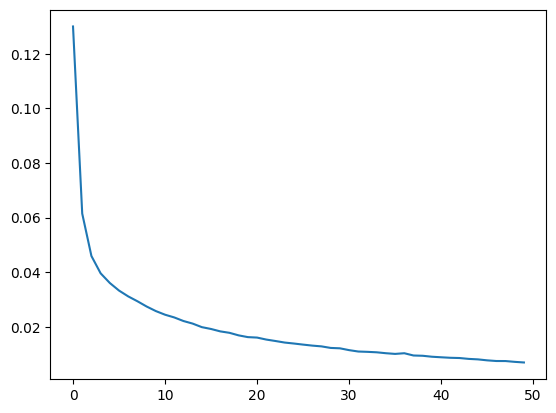

In [33]:
# Plot Training vs Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs test Loss')
plt.legend()
plt.grid(True)
plt.show()



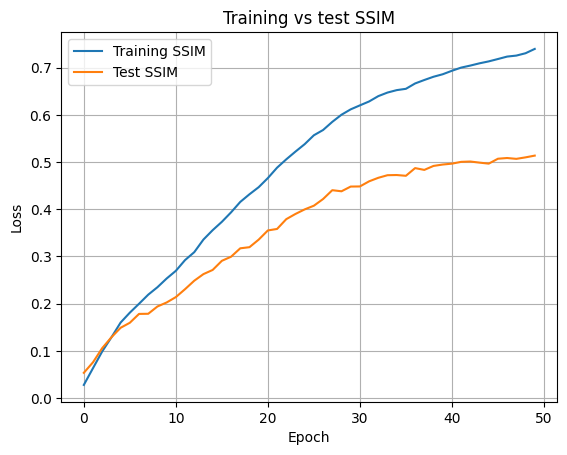

In [18]:
# Plot Training vs Validation Loss
plt.plot(history.history['ssim_metric'], label='Training SSIM')
plt.plot(history.history['val_ssim_metric'], label='Test SSIM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs test SSIM')
plt.legend()
plt.grid(True)
plt.show()


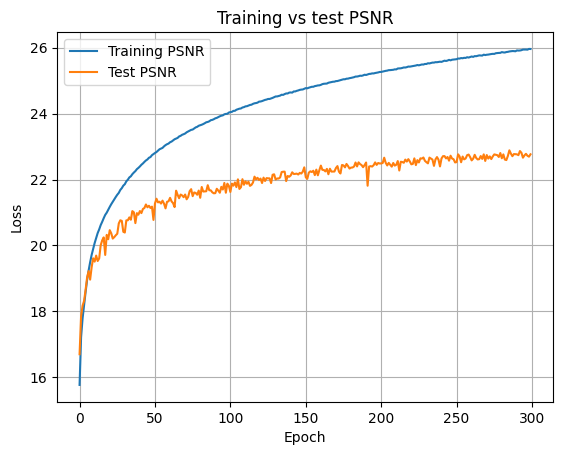

In [21]:
# Plot Training vs Validation Loss
plt.plot(history.history['psnr_metric'], label='Training PSNR')
plt.plot(history.history['val_psnr_metric'], label='Test PSNR')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs test PSNR')
plt.legend()
plt.grid(True)
plt.show()


## Evaluation by Plotting Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


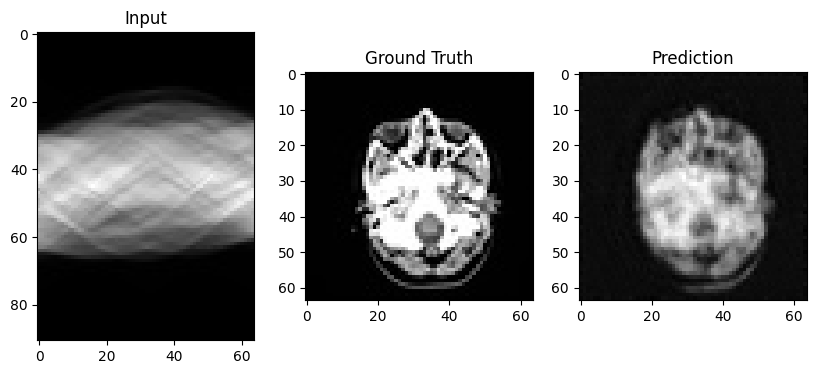

In [19]:
import matplotlib.pyplot as plt

i = 50# index of sample
pred = model.predict(x_train[i:i+1])[0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(x_train[i].squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(y_train[i].squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(pred.squeeze(), cmap='gray')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


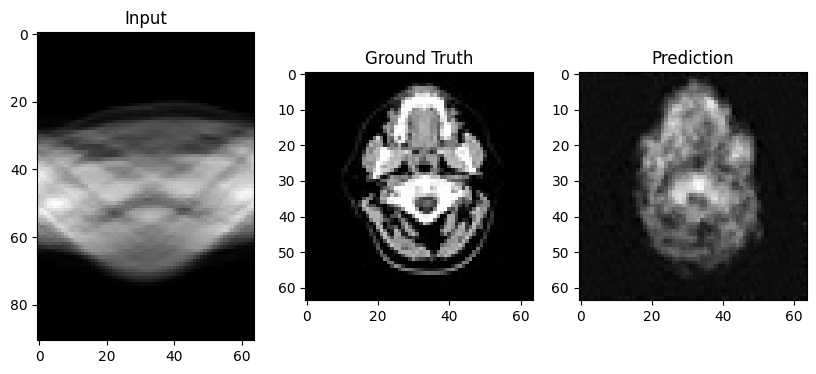

In [21]:
import matplotlib.pyplot as plt

i = 0# index of sample
pred = model.predict(x_test[i:i+1])[0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(x_test[i].squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(y_test[i].squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(pred.squeeze(), cmap='gray')
plt.show()


## Evaluate using PSNR and SSIM

In [22]:
import tensorflow as tf
import numpy as np

total_psnr = 0.0
total_ssim = 0.0
n = len(x_test)

for i in range(n):
    pred = model.predict(x_test[i:i+1], verbose=0)  # shape: (1, 256, 256, 1)
    gt = y_test[i:i+1]

    # Compute PSNR and SSIM
    psnr_val = tf.image.psnr(gt, pred, max_val=1.0).numpy()[0]
    ssim_val = tf.image.ssim(gt, pred, max_val=1.0).numpy()[0]

    total_psnr += psnr_val
    total_ssim += ssim_val

# Average metrics
avg_psnr = total_psnr / n
avg_ssim = total_ssim / n

print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")


Average PSNR: 17.19 dB
Average SSIM: 0.5067


In [23]:
import tensorflow as tf
import numpy as np

total_psnr = 0.0
total_ssim = 0.0
n = len(x_test)

for i in range(n):
    pred = model.predict(x_train[i:i+1], verbose=0)  # shape: (1, 256, 256, 1)
    gt = y_train[i:i+1]

    # Compute PSNR and SSIM
    psnr_val = tf.image.psnr(gt, pred, max_val=1.0).numpy()[0]
    ssim_val = tf.image.ssim(gt, pred, max_val=1.0).numpy()[0]

    total_psnr += psnr_val
    total_ssim += ssim_val

# Average metrics
avg_psnr = total_psnr / n
avg_ssim = total_ssim / n

print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")


Average PSNR: 20.79 dB
Average SSIM: 0.7207


In [ ]:
model.save('automap_v4_dense_300.h5')